<a href="https://colab.research.google.com/github/Manar-Hamed/Arabic_Sign_Language/blob/main/Image_Text_Speech.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# # Mounting Drive
# from google.colab import drive
# drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# Unziping the Images file
# !unzip /content/gdrive/MyDrive/mendeley-data/ArASL_Database_54K_Final.zip -d /content/gdrive/MyDrive/mendeley-data

In [ ]:
# Importing required libraries

# from sklearn.preprocessing import LabelBinarizer
from keras.metrics import Precision, Recall, Accuracy
from sklearn.model_selection import train_test_split
from keras.models import load_model
from keras.utils import plot_model
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow as tf
import numpy as np
import pandas as pd
# import pickle
# import random
import shutil
# import math
import cv2
import os


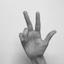

In [ ]:
# Visualizing an Image
img = tf.keras.preprocessing.image.load_img('/content/gdrive/MyDrive/mendeley-data/ArASL_Database_54K_Final/al/AL (1).JPG')
img

In [ ]:
cv2.imread('/content/gdrive/MyDrive/mendeley-data/ArASL_Database_54K_Final/al/AL (1).JPG').shape

(64, 64, 3)

In [ ]:
img.size

(64, 64)

### Loading Images

In [ ]:
# Loading images
data = tf.keras.utils.image_dataset_from_directory('/content/gdrive/MyDrive/mendeley-data/ArASL_Database_54K_Final')

Found 54049 files belonging to 32 classes.


In [ ]:
data_iterator = data.as_numpy_iterator()

In [ ]:
batch = data_iterator.next()

In [ ]:
batch[0].shape

(32, 256, 256, 3)

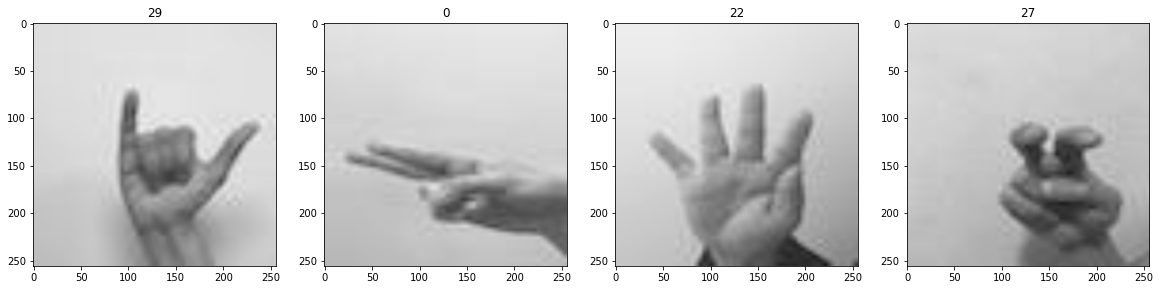

In [ ]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
  ax[idx].imshow(img.astype(int))
  ax[idx].title.set_text(batch[1][idx])

### Scaling Data

In [ ]:
# Scale Data
data = data.map(lambda x,y: (x/255, y))

In [ ]:
scaled_itertor = data.as_numpy_iterator()

In [ ]:
batch = scaled_itertor.next()

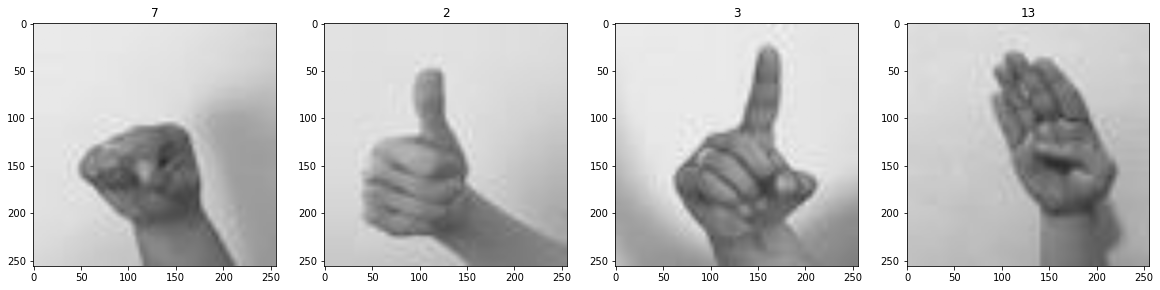

In [ ]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
  ax[idx].imshow(img)
  ax[idx].title.set_text(batch[1][idx])

### Splitting Data

In [ ]:
train_size = int(len(data) * 0.7)
test_size = int(len(data) * 0.2)
valid_size = int(len(data) * 0.1)

In [ ]:
train =  data.take(train_size)
test = data.skip(train_size).take(test_size)
valid = data.skip(train_size+test_size).take(valid_size)

In [ ]:
len(train)

1183

### Creating the CNN Model

In [ ]:
# Defining the CNN

model = keras.models.Sequential()

model.add(keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(256, 256, 3)))
model.add(keras.layers.MaxPooling2D())

model.add(keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(keras.layers.MaxPooling2D())

model.add(keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(keras.layers.MaxPooling2D())

model.add(keras.layers.Flatten())

model.add(keras.layers.Dense(128, activation='relu'))
model.add(keras.layers.Dense(32, activation='softmax'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 32, 32, 128)      0

In [ ]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
save_best_cb = keras.callbacks.ModelCheckpoint('/content/gdrive/MyDrive/models/best_model', save_best_only=True) # Saves the best model so far
early_stopping_cb = keras.callbacks.EarlyStopping(patience=5) # Interupts training when there is no progress

#### Training

In [ ]:
history = model.fit(train, epochs=20, validation_data=test, callbacks=[save_best_cb, early_stopping_cb])

Epoch 1/20
  46/1183 [>.............................] - ETA: 1:21:11 - loss: 3.6220 - accuracy: 0.0374

In [ ]:
history.history # Contains the training related information for each epoch

#### Performance Plotting

In [ ]:
fig = plt.figure()
plt.plot(history.history['loss'], color='teal', label='loss')
plt.plot(history.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc='upper left')
plt.show()

In [ ]:
fig = plt.figure()
plt.plot(history.history['accuracy'], color='teal', label='accuracy')
plt.plot(history.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc='upper left')
plt.show()

### Evaluate Performance

In [ ]:
pre = Precision()
re = Recall()
acc = Accuracy()

In [ ]:
for batch in valid.as_numpy_iterator():
  x, y = batch
  yhat = model.predict(x)
  pre.update_state(y, yhat)
  re.update_state(y, yhat)
  acc.update_state(y, yhat)

In [ ]:
print(f'Precision: {pre.result().nupmy()}, Recall: {re.result().numpy()}, Accuracy: {acc.result().numpy()}')

### Save Model

In [ ]:
# Saving the model
model.save('/content/gdrive/MyDrive/models/ArSLText.h5')

In [ ]:
ArSL_model = load_model('/content/gdrive/MyDrive/models/ArSLText.h5')

In [ ]:
# Loading Best Saved Model
# ArSL_model = load_model('/content/gdrive/MyDrive/models/best_model')

### Converting Images to Sentences

In [ ]:
# test -> Test Set

##### Making Arabic Letters Labels

In [ ]:
encoded_labels = pd.DataFrame()

In [ ]:
# Classes Dictionary
label = pd.read_csv('/content/gdrive/MyDrive/mendeley-data/ArSL_Data_Labels.csv')

In [ ]:
label.head(3)

,#,File_Name,Class
0,1,AIN (1).JPG,ain
1,2,AIN (10).JPG,ain
2,3,AIN (100).jpg,ain


In [ ]:
encoded_labels['Phonteics'] = label['Class'].unique()

In [ ]:
numbers  = [i for i in range(32)]

In [ ]:
encoded_labels['Index'] = numbers

In [ ]:
arab_list = list()

In [ ]:
for eng_lab in  label['Class'].unique():
  print('English Label: ', eng_lab)
  arab_lab = input('Arabic Label: ')
  arab_list.append(arab_lab)

In [ ]:
encoded_labels['ِArabic_Letters'] = arab_list

In [ ]:
encoded_labels.head(3)

,Phonteics,Index,ِArabic_Letters
0,ain,0,ع
1,al,1,ال
2,aleff,2,أ


In [ ]:
encoded_labels.to_csv('/content/gdrive/MyDrive/mendeley-data/Arabic_Letters_Guide.csv', index=False)

#### .........................................

In [ ]:
encoded_labels = pd.read_csv('/content/gdrive/MyDrive/mendeley-data/Arabic_Letters_Guide.csv')
encoded_labels.head(3)

,Phonteics,Index,ِArabic_Letters
0,ain,0,ع
1,al,1,ال
2,aleff,2,أ


In [ ]:
# Actual_Word = 'لغة'
Predicted = ''

In [ ]:
test = tf.keras.utils.image_dataset_from_directory('/content/gdrive/MyDrive/mendeley-data/Test')

batch = test.as_numpy_iterator().next()
x, y = batch

predicted = ArSL_model.predict(x)

letter = encoded_labels[encoded_labels['Index'] == predicted]
arab_letter = letter['Arabic_Letters']

Predicted += arab_letter

In [ ]:
# value = ArSL_model.predict(data.random())
# phon = label_dict[value]
# arabicLetter = arab_dict[phon]

NameError: ignored

In [ ]:
arabicLetter